# Figures 1

## Setup

In [2]:
from __future__ import print_function
import os, sys
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.unicode'] = True
plt.rcParams['image.cmap'] = 'viridis'


sys.path.insert(0, '../')

## Load data and GNTK

In [3]:
from cornet_exp.util import load_data
from cornet_exp.gntk import GNTK
import scipy
from multiprocessing import Pool

graphs, _  = load_data('MUTAG', False)
labels = np.array([g.label for g in graphs]).astype(int)

layers=300

gntk = GNTK(num_layers=layers,  num_mlp_layers=3, jk=0, scale='degree')
A_list = []
diag_list = []

# procesing the data
for i in range(len(graphs)):
    n = len(graphs[i].neighbors)
    for j in range(n):
        graphs[i].neighbors[j].append(j)

        
    edges = graphs[i].g.edges
    m = len(edges)

    row = [e[0] for e in edges]
    col = [e[1] for e in edges]

    A_list.append(scipy.sparse.coo_matrix(([1] * len(edges), (row, col)), shape = (n, n), dtype = np.float32))
    A_list[-1] = A_list[-1] + A_list[-1].T + scipy.sparse.identity(n)
    diag = gntk.diag(graphs[i], A_list[i])
    diag_list.append(diag)  
    
def calc(T):
    return gntk.gntk(graphs[T[0]], graphs[T[1]], diag_list[T[0]], diag_list[T[1]], A_list[T[0]], A_list[T[1]])


calc_list = [(3,7)]

sigma_list = []
ntk_list = []

for liste in calc_list:
    print (liste)
    results, sigma_ab, ntk_ab,dotsigma_ab = calc(liste)
    sigma_list.append(sigma_ab)
    ntk_list.append(ntk_ab)

node_number1 = len(graphs[3].g.node)
node_number2 = len(graphs[7].g.node)    

loading data
# classes: 2
# maximum node tag: 7
# data: 188
(3, 7)
(23, 19)


In [4]:
leng = len(ntk_list[0])

element_sigma = np.zeros((1,node_number1*node_number2,leng))
element_ntk = np.zeros((1,node_number1*node_number2,leng))

for i in range(leng):
    for n1 in range(node_number1):
        for n2 in range(node_number2):
            index = n1+n2*node_number1
            for j in range(1):
                element_sigma[j,index,i] = sigma_list[j][i][n1][n2]
                element_ntk[j,index,i] = ntk_list[j][i][n1][n2]


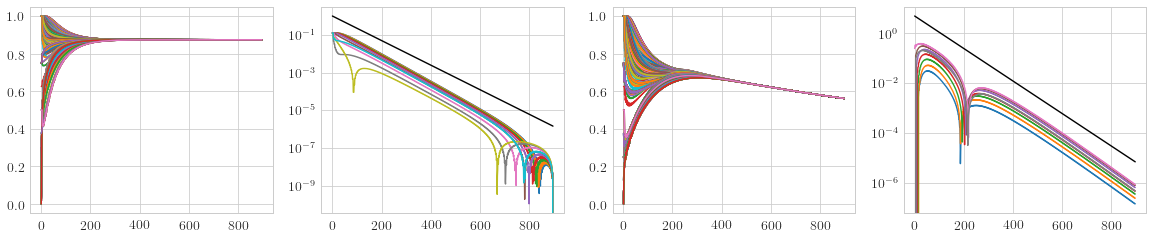

In [5]:
plt.figure(figsize=(20, 3.8))
gs = plt.GridSpec(1, 4)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

t = np.arange(leng)
yt1 = np.exp(-0.015*t)
yt2 = np.exp(-0.015*t)

plt.subplot(gs[0, 0])
for i in range(node_number1*node_number2):
    plt.plot(element_sigma[0][i])
    
plt.subplot(gs[0, 1])  
plt.semilogy(t,yt1,'black')
for i in range(10):
    plt.semilogy(np.abs(element_sigma[0][i]-element_sigma[0][i][-1]))    
    
plt.subplot(gs[0, 2])  
#plt.semilogy(t,yt1,'black')
for i in range(node_number1*node_number2):
    plt.plot(t+1,element_ntk[0][i]/(t+1) )       
    
plt.subplot(gs[0, 3])
plt.semilogy(t,5*yt1,'black')
for i in range(2,10):
    plt.semilogy(np.abs(element_ntk[0][i]/(t+1)-element_ntk[0][0]/(t+1)))    

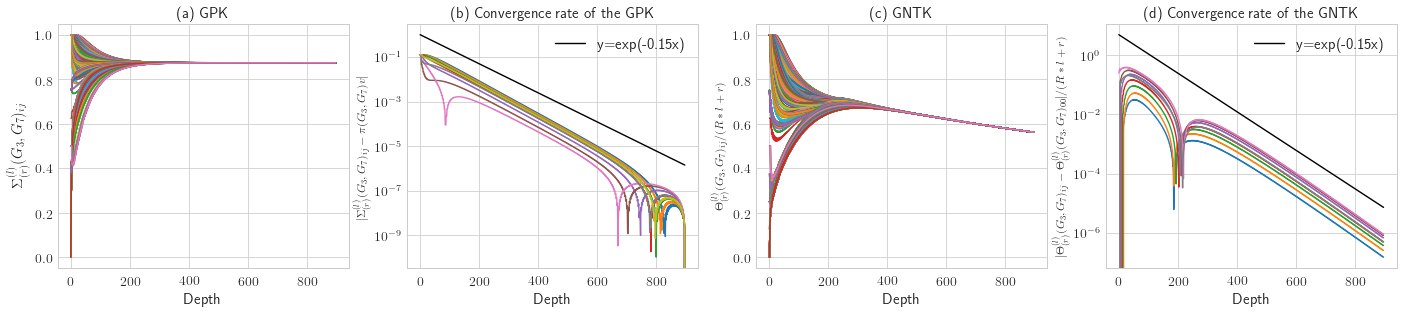

In [6]:
plt.figure(figsize=(24, 4.5))
gs = plt.GridSpec(1, 4)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14)

plt.subplot(gs[0, 0])

for i in range(node_number1*node_number2):
    plt.plot(element_sigma[0][i])

plt.xlabel('Depth', fontsize=15); plt.ylabel('$\Sigma^{(l)}_{(r)}(G_3,G_7)_{ij}$', fontsize=15)
plt.title('(a) GPK', fontsize=15)


plt.subplot(gs[0, 1])
plt.semilogy(t,yt1,'black',label='y=exp(-0.15x)')
for i in range(2,11):
    plt.semilogy(np.abs(element_sigma[0][i]-element_sigma[0][i][-1]))    
plt.xlabel('Depth', fontsize=15); plt.ylabel('$|\Sigma^{(l)}_{(r)}(G_3,G_7)_{ij} - \pi(G_3,G_7) v|$', fontsize=12)
plt.title('(b)  Convergence rate of the GPK', fontsize=15)
plt.legend(fontsize=15)

plt.subplot(gs[0, 2])
#plt.xticks([0, 0.5, 1]); plt.yticks([0, 0.5, 1]); plt.xlim(0, 1); plt.ylim(0, 1)
for i in range(node_number1*node_number2):
    plt.plot(t+1,element_ntk[0][i]/(t+1) )
plt.xlabel('Depth', fontsize=15); plt.ylabel('$\Theta^{(l)}_{(r)}(G_3,G_7)_{ij}/(R*l+r)$', fontsize=12)
plt.title('(c) GNTK', fontsize=15)


plt.subplot(gs[0, 3])
#plt.xticks([0, 0.5, 1]); plt.yticks([0, 0.5, 1]); plt.xlim(0, 1); plt.ylim(0, 1)
plt.semilogy(t,5*yt1,'black',label='y=exp(-0.15x)')
for i in range(2,10):
    plt.semilogy(np.abs(element_ntk[0][i]/(t+1)-element_ntk[0][0]/(t+1)))    
plt.xlabel('Depth', fontsize=15); plt.ylabel('$|\Theta^{(l)}_{(r)}(G_3,G_7)_{ij} - \Theta^{(l)}_{(r)}(G_3,G_7)_{00}|/(R*l+r) $', fontsize=12)
plt.title('(d) Convergence rate of the GNTK', fontsize=15)
plt.legend(fontsize=15)

plt.savefig("fig1_convergence.pdf" ,  bbox_inches='tight')